## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!sudo apt-get install tree

In [ ]:
!tree /content/drive/MyDrive/sensor_kmitl

## Train

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the path to your dataset
dataset_path = '/content/drive/MyDrive/sensor_kmitl/'

# Function to load data
def load_data(path):
    data = []
    labels = []
    max_length = 0

    for label_dir in ['anormal', 'normal']:
        class_dir = os.path.join(path, label_dir)
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            df = pd.read_csv(file_path)
            temp_values = df['temp'].values
            data.append(temp_values)
            labels.append(1 if label_dir == 'anormal' else 0)
            if len(temp_values) > max_length:
                max_length = len(temp_values)

    # Pad sequences
    data = pad_sequences(data, maxlen=max_length, dtype='float32', padding='post', truncating='post')
    return np.array(data), np.array(labels)

# Load the data
data, labels = load_data(dataset_path)

# Normalize the data
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

# Reshape data for LSTM
data = data.reshape(data.shape[0], data.shape[1], 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


### Evaluate

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anormal'], yticklabels=['Normal', 'Anormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### additional matrix

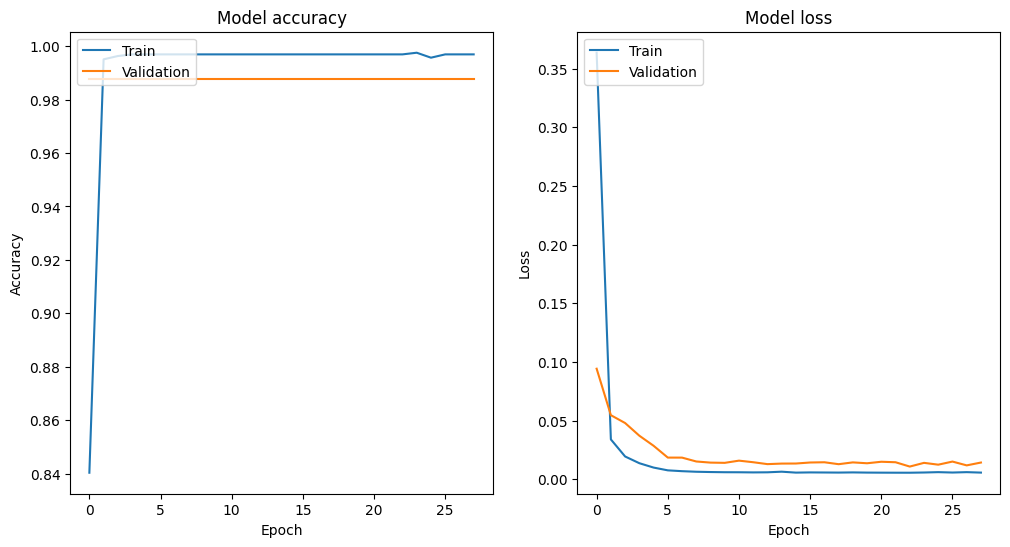

In [ ]:
# Plot evaluation metrics
plt.figure(figsize=(12, 6))

# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


### additional v2

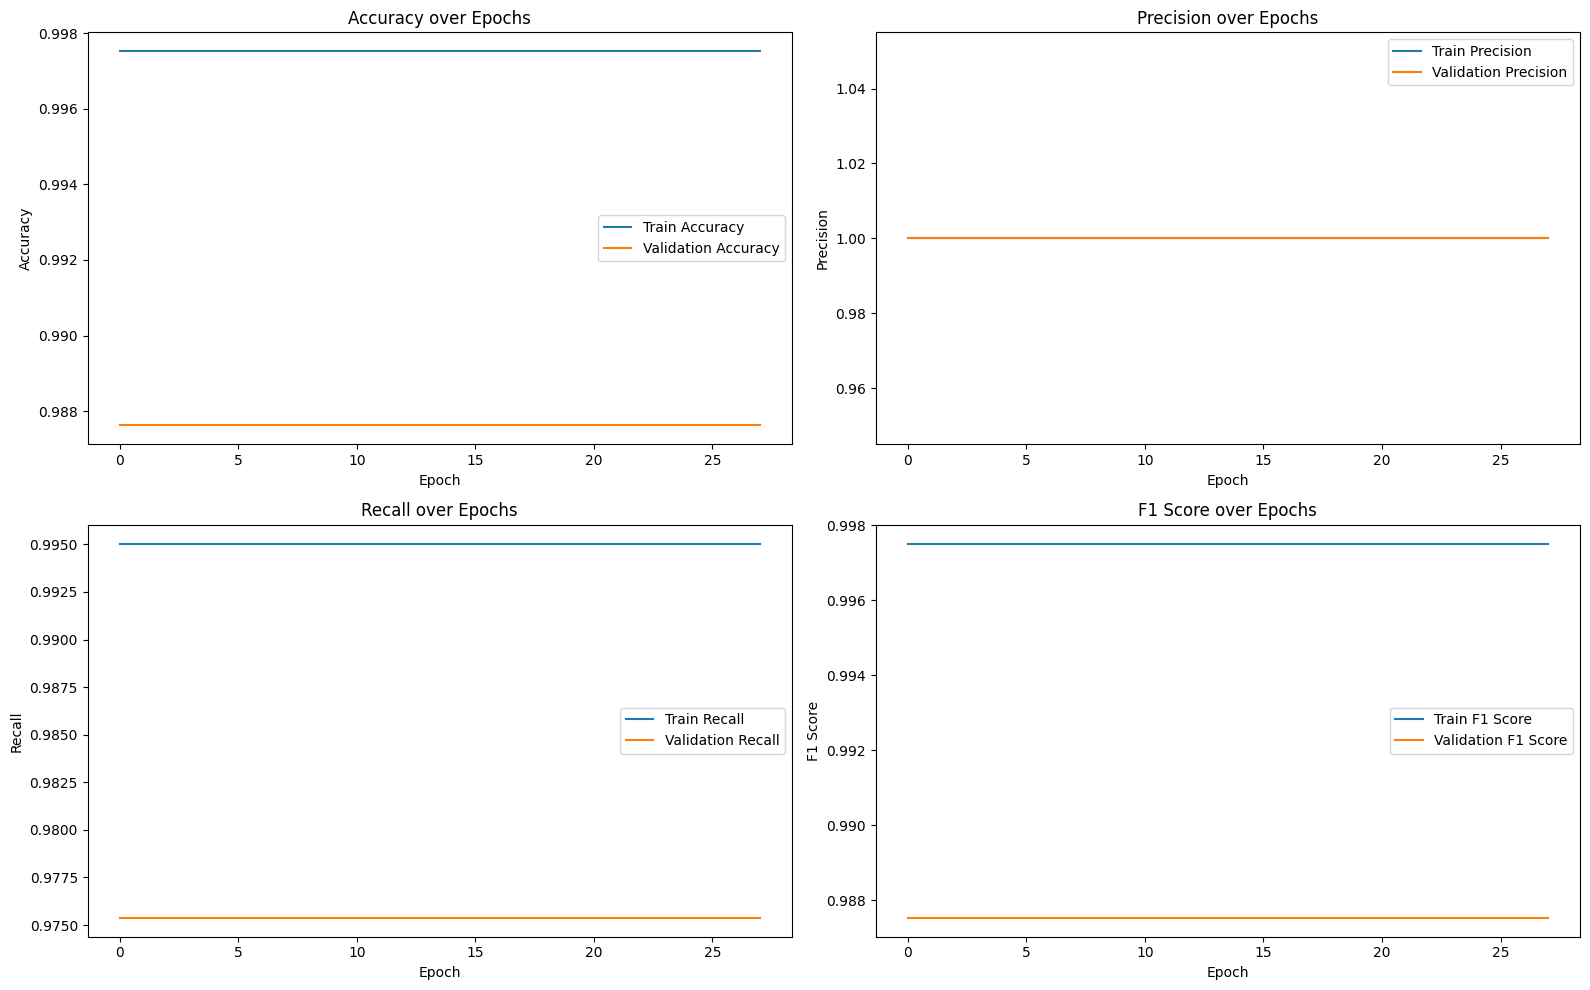

In [ ]:
# Plot additional metrics
plt.figure(figsize=(16, 10))
# Calculate additional metrics across epochs
train_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
val_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
for epoch in range(len(history.history['loss'])):
    y_train_pred = (model.predict(X_train) > 0.5).astype("int32")
    y_val_pred = (model.predict(X_test) > 0.5).astype("int32")

    train_metrics['accuracy'].append(accuracy_score(y_train, y_train_pred))
    train_metrics['precision'].append(precision_score(y_train, y_train_pred))
    train_metrics['recall'].append(recall_score(y_train, y_train_pred))
    train_metrics['f1_score'].append(f1_score(y_train, y_train_pred))

    val_metrics['accuracy'].append(accuracy_score(y_test, y_val_pred))
    val_metrics['precision'].append(precision_score(y_test, y_val_pred))
    val_metrics['recall'].append(recall_score(y_test, y_val_pred))
    val_metrics['f1_score'].append(f1_score(y_test, y_val_pred))
plt.subplot(2, 2, 1)
plt.plot(train_metrics['accuracy'], label='Train Accuracy')
plt.plot(val_metrics['accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_metrics['precision'], label='Train Precision')
plt.plot(val_metrics['precision'], label='Validation Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_metrics['recall'], label='Train Recall')
plt.plot(val_metrics['recall'], label='Validation Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_metrics['f1_score'], label='Train F1 Score')
plt.plot(val_metrics['f1_score'], label='Validation F1 Score')
plt.title('F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

### plot the architechture

In [ ]:
!pip install pydot
!sudo apt-get install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


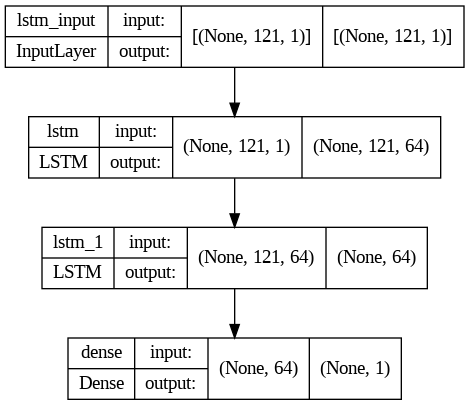

In [ ]:

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
plot_model(model, to_file='/content/model_architecture.png', show_shapes=True, show_layer_names=True)